# Test 6: with preprocessing 
Adding some preprocessing to the datasets before training and feature engineering.

## Collecting datasets

In [60]:
import pandas as pd
import xgboost as xgb
import numpy as np

In [61]:
train = pd.read_csv('ais_train.csv', sep='|')
train['time'] = pd.to_datetime(train['time'])
print(train.head())

test = pd.read_csv('ais_test.csv', sep=',')
test['time'] = pd.to_datetime(test['time'])
print(test.head())

vessels = pd.read_csv('vessels.csv', sep='|')
print(vessels.head())

ports = pd.read_csv('ports.csv', sep='|')
print(ports.head())

                 time    cog   sog  rot  heading  navstat       etaRaw  \
0 2024-01-01 00:00:25  284.0   0.7    0       88        0  01-09 23:00   
1 2024-01-01 00:00:36  109.6   0.0   -6      347        1  12-29 20:00   
2 2024-01-01 00:01:45  111.0  11.0    0      112        0  01-02 09:00   
3 2024-01-01 00:03:11   96.4   0.0    0      142        1  12-31 20:00   
4 2024-01-01 00:03:51  214.0  19.7    0      215        0  01-25 12:00   

   latitude  longitude                  vesselId                    portId  
0 -34.74370  -57.85130  61e9f3a8b937134a3c4bfdf7  61d371c43aeaecc07011a37f  
1   8.89440  -79.47939  61e9f3d4b937134a3c4bff1f  634c4de270937fc01c3a7689  
2  39.19065  -76.47567  61e9f436b937134a3c4c0131  61d3847bb7b7526e1adf3d19  
3 -34.41189  151.02067  61e9f3b4b937134a3c4bfe77  61d36f770a1807568ff9a126  
4  35.88379   -5.91636  61e9f41bb937134a3c4c0087  634c4de270937fc01c3a74f3  
   ID                  vesselId                time  scaling_factor
0   0  61e9f3aeb937134a3c

In [62]:
# Mappings for IDs
port_id_mapping = {port_id: idx for idx, port_id in enumerate(train['portId'].unique())}
train['portId'] = train['portId'].map(port_id_mapping)
ports['portId'] = ports['portId'].map(port_id_mapping)

vessel_id_mapping = {vessel_id: idx for idx, vessel_id in enumerate(train['vesselId'].unique())}
train['vesselId'] = train['vesselId'].map(vessel_id_mapping)
vessels['vesselId'] = vessels['vesselId'].map(vessel_id_mapping)
test['vesselId'] = test['vesselId'].map(vessel_id_mapping)

shipping_line_id_mapping = {shipping_line_id: idx for idx, shipping_line_id in enumerate(vessels['shippingLineId'].unique())}
vessels['shippingLineId'] = vessels['shippingLineId'].map(shipping_line_id_mapping)

## Preprocessing
Need to preprocess the data before feature engineering

In [63]:
# Earth's radius in nautical miles
R = 3440 

def lat_lon_to_cartesian(lat, lon):
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    x = R * np.cos(lat_rad) * np.cos(lon_rad)
    y = R * np.cos(lat_rad) * np.sin(lon_rad)
    z = R * np.sin(lat_rad)
    return x, y, z

def preprocess(train):
    train = train.copy()
    train_grouped = train.groupby('vesselId')
    train = train_grouped.apply(lambda x: x.sort_values('time'))

    # No outliers in cog and sog columns
    # Changing longitude and latitude into cartesian coordinates
    R = 6371
    train['x'] = R * train['longitude'] * 3.14159265359 / 180
    train['y'] = R * train['latitude'] * 3.14159265359 / 180    


    return train







In [103]:
import geopy.distance

def merge_with_ports(features, ports):
    features = features.copy()
    ports = ports.copy()

    # Dropping the irrelevant columns in ports
    ports = ports.drop(['name', 'portLocation', 'UN_LOCODE', 'countryName', 'ISO'], axis=1, errors='ignore')

    # Renaming longitude and latitude columns in ports to portLongitude and portLatitude
    ports = ports.rename(columns={'longitude': 'portLongitude', 'latitude': 'portLatitude'})

    # Merging the features with the ports on portId
    features = features.merge(ports, on='portId', how='right')

    # Dropping the portId column
    features = features.dropna(subset=['portId'])

    # Dropping rows with NaN values in latitude_2 and longitude_2 columns
    features = features.dropna(subset=['latitude_2', 'longitude_2'])

    # Calculating the distance between the vessel and the port
    features['distance_to_port'] = features.apply(lambda x: geopy.distance.distance((x['latitude_1'], x['longitude_1']), (x['portLatitude'], x['portLongitude'])).nm, axis=1)


    return features

def feature_engineering(test, train):
    test = test.copy()
    train = train.copy()
    features = pd.DataFrame()

    # Add the columns vesselId, time, latitude, longitude, cog and sog to the features from train
    features['vesselId'] = train['vesselId']
    features['portId'] = train['portId']
    features['time'] = train['time']
    features['latitude'] = train['latitude']
    features['longitude'] = train['longitude']
    features['cog'] = train['cog']
    features['sog'] = train['sog']
    features['rot'] = train['rot']

    # Create a new binary column for 'under_way' based on the navstat column in train. 
    # 1 if navstat is 0 or 8, 0 otherwise
    features['under_way'] = train['navstat'].isin([0, 8]).astype(int)

    # Adding the columns latitude_1 (last seen latitude) and longitude_1 (last senn longitude)
    # to the features from train. For each vessel
    # Also adding time_1 (time difference from current time to last seen time)
    features['latitude_1'] = train.groupby('vesselId')['latitude'].shift(1)
    features['longitude_1'] = train.groupby('vesselId')['longitude'].shift(1)
    features['time_1'] = train.groupby('vesselId')['time'].diff().dt.total_seconds()

    # Adding the columns latitude_2 (second last seen latitude) and longitude_2 (second last seen longitude)
    # to the features from train. For each vessel
    # Also adding time_2 (time difference from current time to second last seen time)
    features['latitude_2'] = train.groupby('vesselId')['latitude'].shift(2)
    features['longitude_2'] = train.groupby('vesselId')['longitude'].shift(2)
    features['time_2'] = train.groupby('vesselId')['time'].diff(2).dt.total_seconds()

    # Adding the columns latitude_3 (third last seen latitude) and longitude_3 (third last seen longitude)
    # to the features from train. For each vessel
    # Also adding time_3 (time difference from current time to third last seen time)
    features['latitude_3'] = train.groupby('vesselId')['latitude'].shift(3)
    features['longitude_3'] = train.groupby('vesselId')['longitude'].shift(3)
    features['time_3'] = train.groupby('vesselId')['time'].diff(3).dt.total_seconds()


    # Dropping the rows with NaN values
    features = features.dropna()

    # Split the time column into month, day, hour, minute and second columns
    features['month'] = train['time'].dt.month
    features['day'] = train['time'].dt.day
    features['hour'] = train['time'].dt.hour
    features['minute'] = train['time'].dt.minute
    features['second'] = train['time'].dt.second

    features.drop('time', axis=1, inplace=True)

    features = features.dropna()

    # Merge the features with the ports
    features = merge_with_ports(features, ports)

    # Add the feature 'changed_port' to the features.
    # 1 if the vessel has changed port, 0 otherwise
    features['changed_port'] = features['portId'] != features['portId'].shift(1)

    # Drop the portId column
    features = features.drop('portId', axis=1)

    return features

features = feature_engineering(test, train)
print(features.head())


   vesselId  latitude  longitude    cog   sog  rot  under_way  latitude_1  \
0      34.0  37.19372    2.39200   73.0  14.9  0.0        1.0    36.86164   
1     193.0  37.51962    4.19320  265.8  17.6  0.0        1.0    37.86319   
2     193.0  37.50461    3.92923  265.4  18.2  0.0        1.0    37.51962   
3     193.0  37.50028    3.86355  265.1  18.4  0.0        1.0    37.50461   
4     200.0  37.79213    1.91092  263.0  15.9  0.0        1.0    36.43402   

   longitude_1    time_1  ...    time_3  month   day  hour  minute  second  \
0      0.59590   20424.0  ...   25332.0    1.0  15.0  16.0    34.0    46.0   
1     11.28829   94948.0  ...   97126.0    1.0  16.0  22.0    54.0     9.0   
2      4.19320    2551.0  ...   98434.0    1.0  16.0  23.0    36.0    40.0   
3      3.92923     617.0  ...   98116.0    1.0  16.0  23.0    46.0    57.0   
4     14.25912  132887.0  ...  134327.0    1.0  24.0   3.0    57.0    46.0   

   portLongitude  portLatitude  distance_to_port  changed_port  
0  

/var/folders/2r/r1svlpw12qzcycp2c9vw0p200000gn/T/ipykernel_49823/211122718.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vessel_data['combined_time'] = pd.to_datetime({
/var/folders/2r/r1svlpw12qzcycp2c9vw0p200000gn/T/ipykernel_49823/211122718.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vessel_data.sort_values('combined_time', inplace=True)


KeyError: 'portId'

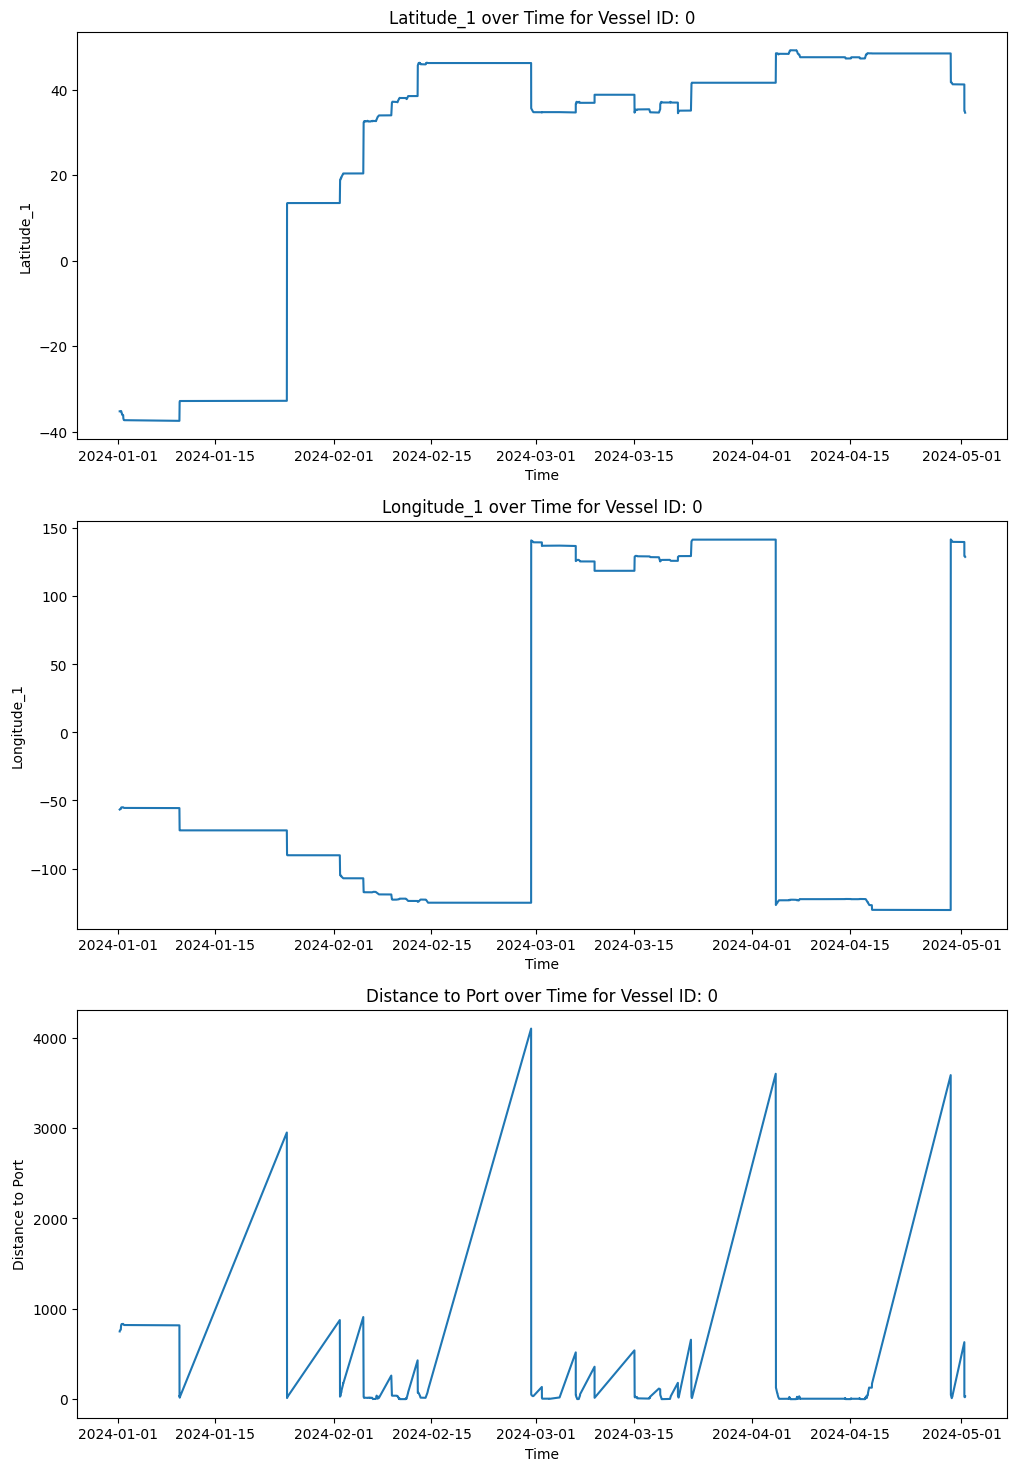

In [104]:
import matplotlib.pyplot as plt

def plot_vessel(vessel_id, features):
    vessel_data = features[features['vesselId'] == vessel_id]
    
    # Combine time components into a single datetime column
    vessel_data['combined_time'] = pd.to_datetime({
        'year': 2024,  # Assuming the year is 2024 as in the last_features DataFrame
        'month': vessel_data['month'].astype(int),
        'day': vessel_data['day'].astype(int),
        'hour': vessel_data['hour'].astype(int),
        'minute': vessel_data['minute'].astype(int),
        'second': vessel_data['second'].astype(int)
    })

    vessel_data.sort_values('combined_time', inplace=True)
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    
    # Plot latitude_1
    axs[0].plot(vessel_data['combined_time'], vessel_data['latitude_1'])
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Latitude_1')
    axs[0].set_title('Latitude_1 over Time for Vessel ID: {}'.format(vessel_id))
    
    # Plot longitude_1
    axs[1].plot(vessel_data['combined_time'], vessel_data['longitude_1'])
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Longitude_1')
    axs[1].set_title('Longitude_1 over Time for Vessel ID: {}'.format(vessel_id))
    
    # Plot distance_to_port
    axs[2].plot(vessel_data['combined_time'], vessel_data['distance_to_port'])
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Distance to Port')
    axs[2].set_title('Distance to Port over Time for Vessel ID: {}'.format(vessel_id))
    
    # Add vertical lines when the vessel changes port
    port_changes = vessel_data[vessel_data['portId'].diff() != 0]
    for ax in axs:
        for change_time in port_changes['combined_time']:
            ax.axvline(x=change_time, color='r', linestyle='--', lw=0.5)
    
    plt.tight_layout()
    plt.show()

plot_vessel(0, features)

In [105]:
def find_last_features(features):
    # Assuming that the last row for every vesselId is the most recent
    last_features = features.groupby('vesselId').last().reset_index()
    return last_features

last_features = find_last_features(features)
print(last_features.head())
print(last_features.shape)

   vesselId  latitude  longitude    cog   sog  rot  under_way  latitude_1  \
0       0.0  33.49441 -118.11668  340.1  14.8  0.0        1.0    33.41677   
1       1.0  25.00311   51.60003  332.1   0.0  0.0        0.0    25.00310   
2       2.0  25.64170   55.18303   64.0  17.9  0.0        1.0    25.57607   
3       3.0  34.24098  128.70951  249.2  15.6  0.0        1.0    34.27837   
4       4.0  25.36577  -18.89828  183.8  18.6  0.0        1.0    25.46969   

   longitude_1  time_1  ...   time_3  month   day  hour  minute  second  \
0   -118.08224  1221.0  ...   3679.0    2.0   7.0   5.0    38.0    20.0   
1     51.60005   720.0  ...   3960.0    3.0  20.0   1.0     2.0    54.0   
2     55.06688  1524.0  ...   3192.0    2.0  22.0   4.0    51.0    29.0   
3    128.78155   978.0  ...   3444.0    4.0  19.0   9.0    12.0    28.0   
4    -18.89101  1208.0  ...  35049.0    1.0   3.0   2.0     5.0    48.0   

   portLongitude  portLatitude  distance_to_port  changed_port  
0     -117.91700     

In [106]:
# Define features and target
y = features[['latitude', 'longitude']]  
X = features.drop(columns=['latitude', 'longitude']) 

In [107]:
# Initialize the xgboost model
model = xgb.XGBRegressor()

# Fit the model
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [108]:
### Prepare test data for predictions
def prepare_test_for_predictions(test, last_features):
    test = test.copy()
    prepared_test = pd.DataFrame()

    # Create a time column in last features
    last_features['year'] = 2024
    last_features['time'] = pd.to_datetime(
        last_features[['year', 'month', 'day', 'hour', 'minute', 'second']]
    )
    last_features =last_features.drop(columns=['longitude_3', 'latitude_3', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_3']).copy()


    # Add the columns vesselId and time
    prepared_test['vesselId'] = test['vesselId']
    prepared_test['time'] = test['time']

    # For each vessel, add the last seen features to the prepared test
    prepared_test = prepared_test.merge(last_features, on='vesselId', how='left', suffixes=('', '_last'))

    # Add the empty columns latitude_3, longitude_3 and time_3 to the prepared test
    prepared_test['latitude_3'] = None
    prepared_test['longitude_3'] = None
    prepared_test['time_3'] = None


    # For each row, latitude_3 should be the same as latitude_2, longitude_3 should be the same as longitude_2
    # and time_3 should be the same as time_2
    prepared_test['latitude_3'] = prepared_test['latitude_2']
    prepared_test['longitude_3'] = prepared_test['longitude_2']
    prepared_test['time_3'] = prepared_test['time_2']

    # Same for latitude_2, longitude_2 and time_2
    prepared_test['latitude_2'] = prepared_test['latitude_1']
    prepared_test['longitude_2'] = prepared_test['longitude_1']
    prepared_test['time_2'] = prepared_test['time_1']

    # Same for latitude_1, longitude_1 and time_1
    prepared_test['latitude_1'] = prepared_test['latitude']
    prepared_test['longitude_1'] = prepared_test['longitude']

    # Time_1 should be the difference between the current time and the last seen time
    prepared_test['time_1'] = (prepared_test['time'] - prepared_test['time_last']).dt.total_seconds()

    # For each time column (time_2, time_3), add the rows value in time_1
    prepared_test['time_2'] += prepared_test['time_1']
    prepared_test['time_3'] += prepared_test['time_1']

    # Drop the the latitude and longitude columns
    prepared_test.drop(columns=['latitude', 'longitude'], inplace=True)
    print(prepared_test.shape)

    # Split the time column into month, day, hour, minute and second columns
    prepared_test['month'] = test['time'].dt.month
    prepared_test['day'] = test['time'].dt.day
    prepared_test['hour'] = test['time'].dt.hour
    prepared_test['minute'] = test['time'].dt.minute
    prepared_test['second'] = test['time'].dt.second

    prepared_test.drop('time', axis=1, inplace=True)
    prepared_test.drop('time_last', axis=1, inplace=True)

    # Calculate the distance between latitude_2, longitude_2 and portLongitude, portLatitude
    prepared_test['distance_to_port'] = prepared_test.apply(
        lambda x: geopy.distance.distance((x['latitude_1'], x['longitude_1']), (x['portLatitude'], x['portLongitude'])).nm, axis=1
    )

    return prepared_test

print(test.head())
test_df = prepare_test_for_predictions(test, last_features)
print(test_df.head())
print(test_df.shape)


   ID  vesselId                time  scaling_factor
0   0       412 2024-05-08 00:03:16             0.3
1   1       373 2024-05-08 00:06:17             0.3
2   2       181 2024-05-08 00:10:02             0.3
3   3         8 2024-05-08 00:10:34             0.3
4   4        65 2024-05-08 00:12:27             0.3
(51739, 20)
   vesselId    cog   sog   rot  under_way  latitude_1  longitude_1     time_1  \
0       412   23.9  10.0  15.0        1.0    13.02690    100.78440  4325720.0   
1       373   40.7  12.2   0.0        1.0    23.79480    118.46412  5576298.0   
2       181  265.0  16.8   0.0        1.0    38.25200     12.90873    78373.0   
3         8   46.8  10.0   0.0        1.0   -36.40797    175.24413   313627.0   
4        65  241.0  19.2   0.0        1.0    49.95545     -3.05533    34646.0   

   latitude_2  longitude_2  ...  distance_to_port  changed_port  latitude_3  \
0     1.27842    104.31353  ...          6.619249         False     1.25905   
1    23.71666    118.38984  ...

In [109]:
# Reorder columns in test_df to match the training data
test_df = test_df[['vesselId', 'cog', 'sog', 'rot', 'under_way', 'latitude_1', 'longitude_1', 'time_1', 'latitude_2', 'longitude_2', 'time_2', 'latitude_3', 'longitude_3', 'time_3', 'month', 'day', 'hour', 'minute', 'second', 'portLongitude', 'portLatitude', 'distance_to_port', 'changed_port']]

# Make predictions
predictions = model.predict(test_df)
print(predictions)
print(predictions.shape)

[[  17.558065  103.7332  ]
 [  28.898039  115.345634]
 [  38.43639    11.560461]
 ...
 [  29.22476  -102.39637 ]
 [  62.79564   -30.949602]
 [  30.041632  -99.51211 ]]
(51739, 2)


In [111]:
# Create a DataFrame with the required format
predictions_df = pd.DataFrame(predictions, columns=['latitude_predicted', 'longitude_predicted'])
predictions_df['ID'] = range(len(predictions_df))
predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]

# Save to CSV
predictions_df.to_csv('predictions_6.csv', index=False)